In [53]:
import cv2
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.cluster import KMeans
import sys
import warnings
from sklearn.ensemble import RandomForestClassifier
import itertools
import pandas as pd
import os
from sklearn.decomposition import PCA
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings("ignore")
%matplotlib inline

ImportError: No module named statistics

In [2]:
def mins_secs_to_mills(mins, secs):
    return mins * 60 * 1000 + secs * 1000

In [24]:
def sliding_window(image, stepSize, windowSize):
	# slide a window across the image
	for y in xrange(0, image.shape[0], stepSize):
		for x in xrange(0, image.shape[1], stepSize):
			# yield the current window
			yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0],:])

In [99]:
start_time = mins_secs_to_mills(5,20)
cap = cv2.VideoCapture('dodgers-giants-9-24-2014.mov')
cap.set(cv2.cv.CV_CAP_PROP_POS_MSEC, start_time)

True

In [23]:
rf = pickle.load(open('scoreboard-clf.pkl','rb'))
#kmeans = pickle.load(open('rays-kmeans.pkl','rb'))

In [4]:
ret, im = cap.read()

In [12]:
im = cv2.resize(im,(102, 182), interpolation = cv2.INTER_CUBIC)

In [45]:
pickle.dump(im, open('rays-scorebox', 'wb'))

In [1045]:
import warnings
warnings.filterwarnings("ignore")
prev_hist_color = cv2.calcHist([im], [0,1,2], None, [1,2,1], [0,256,0,256,0,256])
prev_hist_color = cv2.normalize(prev_hist_color).flatten()

frames = []

is_pitching = 0

while(1):
    ret, frame = cap.read()
    if not ret:
        break
    new_hist_color = cv2.calcHist([frame], [0,1,2], None, [1,2,1], [0,256,0,256,0,256])
    new_hist_color = cv2.normalize(new_hist_color).flatten()
    color_diff = cv2.compareHist(prev_hist_color, new_hist_color, cv2.cv.CV_COMP_CHISQR)
            
    if color_diff > 0.5:
        if is_pitching:
            is_pitching = 0
        #frames.append(frame)
        else:
            gen = sliding_window(cv2.resize(frame,(102, 182), 
                                            interpolation = cv2.INTER_CUBIC), 
                                             stepSize=20, 
                                             windowSize=(8,8))
            im_kmeans = np.zeros(20)
            for p in gen:
                if p[2].shape == (8,8,3):
                    im_kmeans[kmeans.predict(p[2].flatten().reshape(1,-1)[0])] += 1
            probs = rf.predict_proba(im_kmeans.reshape(1,-1))[0]
            is_pitching = 1 if probs[1] > 0.2 else 0
            plt.imshow(frame)
            plt.show()
            print probs
            sys.stdout.flush()
            
    #if is_pitching:
        #cv2.imshow('frame',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    prev_hist_color = new_hist_color

KeyboardInterrupt: 

In [112]:
template = pickle.load(open('data/rays-scoreboard'))
score_area = pickle.load(open('data/game-info'))
w,h = template.shape[1], template.shape[0]
w2,h2 = score_area.shape[1], score_area.shape[0]
method = 'cv2.TM_CCOEFF'
method = eval(method)
scoreboard_clf = pickle.load(open('models/scoreboard-clf.pkl'))
scoreboard_kmeans = pickle.load(open('models/scoreboard-kmeans.pkl'))
pca = pickle.load(open('models/count1-pca.pkl'))
neighs = pickle.load(open('models/count1-clf.pkl'))
pca2 = pickle.load(open('models/count2-pca.pkl'))
neighs2 = pickle.load(open('models/count2-clf.pkl'))
pitcher_kmeans = pickle.load(open('models/pitching-view-kmeans.pkl'))
pitcher_clf = pickle.load(open('models/pitcher-shot-classifier.pkl'))
located = False
top_left = None
bottom_right = None
tops = []
bottoms = []
min_boxes = 10
balls = -1
strikes = -1
prev_balls = -1
prev_strikes = -1
found_one = False
first_timestamp = None
new_ab = True

i = 0
while(1):

    ret, frame = cap.read()
    if not ret:
        break
        
    totalFrameNumber = cap.get(cv2.cv.CV_CAP_PROP_POS_FRAMES)
    cap.set(cv2.cv.CV_CAP_PROP_POS_FRAMES, int(totalFrameNumber) + 30)
        
    if not located:
        if not found_one:
            first_timestamp = cap.get(cv2.cv.CV_CAP_PROP_POS_MSEC)
            found_one = True
        res = cv2.matchTemplate(frame,template,method)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
        top_left = max_loc
        bottom_right = (top_left[0] + w, top_left[1] + h)
    
    selected = frame[top_left[1]:bottom_right[1],top_left[0]:bottom_right[0]]

    gen = sliding_window(selected, stepSize=5, windowSize=(8,8))
    im_kmeans = np.zeros(40)
    for p in gen:
        if p[2].shape == (8,8,3):
            im_kmeans[scoreboard_kmeans.predict(p[2].flatten().reshape(1,-1)[0])] += 1

    probs = scoreboard_clf.predict_proba(im_kmeans)
    
    if probs[0][1] > 0.5:
        if not located:
            tops.append(top_left)
            bottoms.append(bottom_right)
            if len(tops) == min_boxes:
                top_left = sorted(tops)[min_boxes/2]
                bottom_right = sorted(bottoms)[min_boxes/2]
                cap.set(cv2.cv.CV_CAP_PROP_POS_MSEC,first_timestamp)
                located = True
        else:
            res = cv2.matchTemplate(selected,score_area,method)
            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
            top_left2 = max_loc
            bottom_right2 = (top_left2[0] + w2, top_left2[1] + h2)
            score = selected[top_left2[1]:bottom_right2[1],top_left2[0]:bottom_right2[0]]
            gray = cv2.cvtColor(score[20:30,18:25],cv2.COLOR_BGR2GRAY).flatten()
            transform = pca.transform(gray).reshape(1,-1)[0]

            gray2 = cv2.cvtColor(score[20:30,27:33],cv2.COLOR_BGR2GRAY).flatten()
            transform2 = pca2.transform(gray2).reshape(1,-1)[0]

            balls = neighs.predict(transform)[0]
            strikes = neighs2.predict(transform2)[0]

            if balls == 4 and strikes == 4:
                new_ab = True
        
        if located and is_pitcher_frame(frame, pitcher_clf, pitcher_kmeans):
            cv2.imshow('frame',frame)

    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    i += 1

In [593]:
labels = np.zeros(len(scoreboards))

In [101]:
def is_pitcher_frame(frame, pitcher_clf, pitcher_kmeans):
    
    gen = sliding_window(cv2.resize(frame,(102, 182), 
                                            interpolation = cv2.INTER_CUBIC), 
                                             stepSize=20, 
                                             windowSize=(8,8))
        
    im_kmeans = np.zeros(20)
    for p in gen:
        if p[2].shape == (8,8,3):
            im_kmeans[pitcher_kmeans.predict(p[2].flatten().reshape(1,-1)[0])] += 1
    
    probs = pitcher_clf.predict_proba(im_kmeans.reshape(1,-1))[0]
    return probs[1] >= 0.5

In [592]:
is_scoreboard = [18, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 
                 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 
                 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 67, 68, 
                 69, 71, 72, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 85, 
                 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 100, 101, 102, 103, 
                 104, 105, 106, 107, 108, 109, 113, 114, 115, 116, 117, 118, 
                 120, 122, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 
                 154, 155, 156, 157, 161, 162, 163, 164, 165, 166, 167, 170, 
                 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 200,
                 202, 203, 204, 205, 206, 207, 208, 210, 211, 212, 215, 216,
                 217, 218, 219, 220, 221, 222, 223, 224, 225, 229, 230, 231, 
                 232, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 
                 245, 246, 247, 250, 251, 252, 253, 254, 255, 256, 257, 258, 
                 259, 260, 261, 262, 263, 267, 268, 269, 270, 271, 272, 273, 
                 274, 275]

In [594]:
labels[is_scoreboard] = 1

In [110]:
start_time = mins_secs_to_mills(11,30)
cap = cv2.VideoCapture('videos/rays-indians-05-09-2014.mov')
cap.set(cv2.cv.CV_CAP_PROP_POS_MSEC, start_time)

True

In [69]:
start_time = mins_secs_to_mills(5,10)
cap = cv2.VideoCapture('videos/indians-rangers-6-9-2014.mov')
cap.set(cv2.cv.CV_CAP_PROP_POS_MSEC, start_time)

True

In [2139]:
ret, img = cap.read()

In [2140]:
ret

True

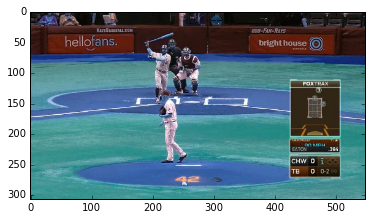

In [2141]:
plt.imshow(img)

In [1350]:
pickle.dump(rays_template, open('data/rays-scoreboard','wb'))

In [662]:
template = pickle.dump(template, open('data/rays-scoreboard','wb'))

In [663]:
template = pickle.load(open('data/rays-scoreboard','rb'))

In [1359]:
w,h = template.shape[1], template.shape[0]

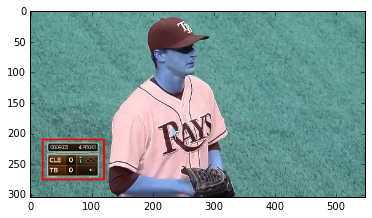

In [1366]:
plt.imshow(img)

In [1697]:
start_time = mins_secs_to_mills(6,14)
cap = cv2.VideoCapture('rays-indians-05-09-2014.mov')
cap.set(cv2.cv.CV_CAP_PROP_POS_MSEC, start_time)

True

In [1192]:
ret, img = cap.read()

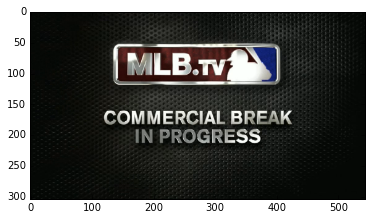

In [1193]:
plt.imshow(img)

In [34]:
score_area = img[213:277,24:115][23:58,37:86])

NameError: name 'img' is not defined

In [715]:
pickle.dump(score_area, open('data/game-info','wb'))

In [1397]:
method = 'cv2.TM_CCOEFF'
method = eval(method)
res = cv2.matchTemplate(img,template,method)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
top_left = max_loc
bottom_right = (top_left[0] + w, top_left[1] + h)
cv2.rectangle(img,top_left, bottom_right, 255, 2)

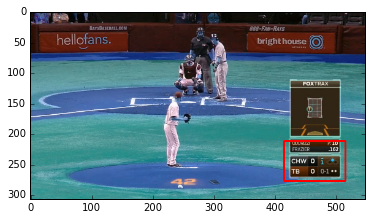

In [1398]:
plt.imshow(img)

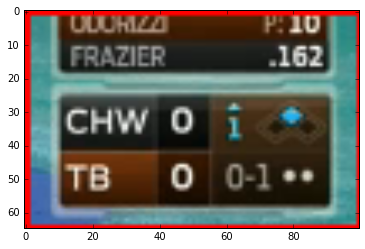

In [1410]:
plt.imshow(img[top_left[1]:bottom_right[1],top_left[0]:bottom_right[0]])

In [1517]:
rf = RandomForestClassifier(n_estimators = 10)
rf.fit(imgs2, labs)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [1518]:
pickle.dump(rf, open('scoreboard-clf.pkl','wb'))

In [1516]:
np.mean(rf.predict(imgs2[70:]) == labs[70:])

0.96875

In [90]:
all_scoreboards = all_scoreboards.extend(scoreboards)

In [17]:
score_area = template[23:57,35:86]

In [96]:
pickle.dump([scoreboards,labels], open('data/sb-04-2014','wb'))

In [102]:
pickle.dump([scoreboards,labels], open('data/sb-04-17-2016','wb'))

In [596]:
pickle.dump([scoreboards,labels], open('data/sb-04-17-2014','wb'))

In [1910]:
s1,l1 = pickle.load(open('data/sb-04-2014','rb'))
s2,l2 = pickle.load(open('data/sb-04-17-2016','rb'))
s3,l3 = pickle.load(open('data/sb-04-17-2014','rb'))

In [1911]:
imgs = []
for im in itertools.chain(s1, s2, s3):
    imgs.append(im)

In [1864]:
labels = np.concatenate((l1,l2,l3))

In [1865]:
labels.shape

(508,)

In [1731]:
def sliding_window(image, stepSize, windowSize):
	# slide a window across the image
	for y in xrange(0, image.shape[0], stepSize):
		for x in xrange(0, image.shape[1], stepSize):
			# yield the current window
			yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0],:])

In [1878]:
def extract_patches_and_features(imgs, patch_size, n_clusters):
    
    patches = []
    for im in imgs:
        patchs = extract_patches_2d(im, patch_size, max_patches=20)
        for p in patchs:
            patches.append(p.flatten())
    
    patches = np.array(patches)
    
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(patches)
    
    out = np.zeros((len(imgs), n_clusters))
    
    for i in range(len(imgs)):
        gen = sliding_window(imgs[i], stepSize=5, windowSize=patch_size)
        im_kmeans = np.zeros(n_clusters)
        for p in gen:
            if p[2].shape == (patch_size[0], patch_size[1] ,3):
                im_kmeans[kmeans.predict(p[2].flatten().reshape(1,-1)[0])] += 1
        out[i] = im_kmeans
        
    return out, kmeans

In [2124]:
out, kmeans = extract_patches_and_features(imgs, (8,8), 40)

In [1831]:
def test_classifier(ftrs, labs, clf, percent=0.7):
    perm = np.random.permutation(len(labs))
    ftrs = ftrs[perm,:]
    labs = labels[perm]

    num = int(percent * len(labs))
    clf.fit(ftrs[:num], labs[:num])
    
    return np.mean(clf.predict(ftrs[num:]) == labs[num:])

In [2125]:
rf = RandomForestClassifier(n_estimators=20)
rf.fit(out, labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [636]:
pickle.dump(rf, open('scoreboard-clf.pkl','wb'))

In [637]:
pickle.dump(kmeans, open('scoreboard-kmeans.pkl','wb'))

In [1095]:
first_nums = [cv2.cvtColor(s[20:30,18:25],cv2.COLOR_BGR2GRAY).flatten() for s in score_areas]

In [1096]:
second_nums = [cv2.cvtColor(s[20:30,27:33],cv2.COLOR_BGR2GRAY).flatten() for s in score_areas]

In [828]:
count_map = {
    0:'00', 
    1:'01', 
    2:'02', 
    3:'10',
    4:'11',
    5:'12',
    6:'20',
    7:'21',
    8:'22',
    9:'30',
    10:'31',
    11:'32'
}

In [1993]:
n1, l1 = pickle.load(open('data/score-areas1'))
n2, l2 = pickle.load(open('data/score-areas2'))

In [2120]:
def get_count_labs(ls, count_map, first=True):
    if first:
        return [4 if count_map[l] == '00' else int(count_map[l][0]) for l in ls]
    else:
        return [4 if count_map[l] == '00' else int(count_map[l][1]) for l in ls]

In [2121]:
def collect_labels(labs_lst, count_map, first=True):
    coll = []
    for labs in labs_lst:
        coll.append(get_count_labs(labs, count_map, first))
    return np.concatenate(tuple(coll))

In [2122]:
def load_count_data(folder, files):
    ims = []
    labs = []
    for f in files:
        im, l = pickle.load(open(os.path.join(folder,f)))
        ims.append(im)
        labs.append(l)
    return ims, labs

In [2131]:
folder = '/Users/jonadelson/Columbia/ComputerVisionBook/data'
files = ['score-areas1', 'score-areas2']
ims, labs = load_count_data(folder, files)

In [2132]:
labs = collect_labels(labs, count_map, first=False)

In [2133]:
def get_count_section(ims, x_area, y_area):
    out = []
    for im in ims:
        transform = [cv2.cvtColor(s[x_area[0]:x_area[1],y_area[0]:y_area[1]],
                                  cv2.COLOR_BGR2GRAY).flatten() for s in im]
        out.append(transform)
    return np.concatenate(tuple(out))

In [2134]:
out = get_count_section(ims, [20, 30], [27, 33])

In [2135]:
pca2 = PCA(n_components=5, whiten=True)
transformed = pca2.fit_transform(out)

In [2136]:
neighs2 = KNeighborsClassifier(n_neighbors=3)
neighs2.fit(transformed, labs)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [1971]:
pickle.dump(neighs, open('models/count1-clf.pkl', 'wb'))

In [2089]:
test_classifier(transformed, labs, neighs2, percent=0.7)

0.57352941176470584

In [1476]:
pickle.dump([score_areas, labels], open('data/score-areas2','wb'))

In [1716]:
pickle.dump(pca, open('models/count1-pca.pkl','wb'))

In [2145]:
pickle.dump(neighs2, open('models/count2-clf.pkl','wb'))

In [2146]:
pickle.dump(pca2, open('models/count2-pca.pkl','wb'))